# Datamodel for the flow network

In [ ]:
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")

from PSFnetflow import Network
from PSFnetflow import NetworkElement
from PSFnetflow import SurveyPlan
from PSFnetflow import Arc
from PSFnetflow import TargetClassToTargetArc
from PSFnetflow import TargetToTargetVisitArc
from PSFnetflow import TargetVisitToCobraVisitArc
from PSFnetflow import CobraVisitToCobraArc
from PSFnetflow import CobraToSinkArc
from PSFnetflow import OverflowArc
from PSFnetflow import Node
from PSFnetflow import Sink
from PSFnetflow import Cobra
from PSFnetflow import CobraVisit
from PSFnetflow import TargetClass
from PSFnetflow import CalTargetClass
from PSFnetflow import SciTargetClass
from PSFnetflow import Target
from PSFnetflow import SciTarget
from PSFnetflow import CalTarget
from PSFnetflow import TargetVisit


In [1]:
from numpy import inf
from collections import OrderedDict

# some simple data model for the network
class Network(object):
    def __init__(self):
        self.nodes = {}
        self.arcs = {}
    
    def add_node(self, node):
        self.nodes[node.id] = node
        
    def add_arc(self, arc):
        self.arcs[arc.id] = arc
        self.nodes[arc.startnode.id].outarcs.append(arc)
        self.nodes[arc.endnode.id].inarcs.append(arc)

        
class NetworkElement(object):
    def __init__(self):
        pass
        
        
class SurveyPlan(Network):
    def __init__(self):
        super(SurveyPlan, self).__init__()
        self.cobras = OrderedDict()
        self.cobraVisits = OrderedDict()
        self.targets = {}
        self.calTargets = OrderedDict()
        self.sciTargets = OrderedDict()
        self.targetVisits = OrderedDict()
        #self.targetClasses = {}
        self.calTargetClasses = OrderedDict()
        self.sciTargetClasses = OrderedDict()
        self.sinks = OrderedDict()
        
    def add_node(self, node):
        super(SurveyPlan, self).add_node(node)
        if type(node) == Cobra:
            self.cobras[node.id] = node
        elif type(node) == CobraVisit:
            self.cobraVisits[node.id] = node
        elif type(node) == CalTarget:
            self.calTargets[node.id] = node
            self.targets[node.id] = node
        elif type(node) == SciTarget:
            self.sciTargets[node.id] = node
            self.targets[node.id] = node
        elif type(node) == TargetVisit:
            self.targetVisits[node.id] = node
        elif type(node) == TargetClass:
            self.targetClasses[node.id] = node
        elif type(node) == CalTargetClass:
            self.calTargetClasses[node.id] = node  
        elif type(node) == SciTargetClass:
            self.sciTargetClasses[node.id] = node            

        elif type(node) == Sink:
            self.sinks[node.id] = node
        else:
            raise Exception("Unknown node type.")

    def get_overflowarcs(self):
        return  filter(lambda a: a == OverflowArc, self.arcs)


# Arc types ...
class Arc(NetworkElement):
    def __init__(self, startnode, endnode):
        super(Arc, self).__init__()
        self.id = "{}->{}".format(startnode.id, endnode.id)
        self.startnode = startnode
        self.endnode = endnode
        self.capacity = 1
        self.cost = 0
        self.flow = 0
        
        
class TargetClassToTargetArc(Arc):
    def __init__(self, startnode, endnode):
        super(TargetClassToTargetArc, self).__init__(startnode, endnode)
        

class TargetToTargetVisitArc(Arc):
    def __init__(self, startnode, endnode):
        super(TargetToTargetVisitArc, self).__init__(startnode, endnode)


class TargetVisitToCobraVisitArc(Arc):
    def __init__(self, startnode, endnode):
        super(TargetVisitToCobraVisitArc, self).__init__(startnode, endnode)
        

class CobraVisitToCobraArc(Arc):
    def __init__(self, startnode, endnode):
        super(CobraVisitToCobraArc, self).__init__(startnode, endnode)


class CobraToSinkArc(Arc):
    def __init__(self, startnode, endnode):
        super(CobraToSinkArc, self).__init__(startnode, endnode)
        self.cost = 0
        self.capacity = inf

        
class OverflowArc(Arc):
    def __init__(self, cost, startnode, endnode):
        super(OverflowArc, self).__init__(startnode, endnode)
        self.cost = cost
        self.capacity = inf

        
# Node types ...      
class Node(NetworkElement):
    def __init__(self, id):
        super(Node, self).__init__()
        self.id = id
        self.capacity = inf
        self.gain = 1
        self.inarcs = []
        self.outarcs = []
        self.supply = 0

        
class Sink(Node):
    def __init__(self, id):
        super(Sink, self).__init__(id)

        
class Cobra(Node):
    def __init__(self, id, x, y):
        super(Cobra, self).__init__(id)
        self.x = x
        self.y = y
        
        
class CobraVisit(Node):
    def __init__(self, id, cobra, visit):
        super(CobraVisit, self).__init__(id)
        self.visit = visit
        self.cobra = cobra
        
        
class TargetClass(Node):
    def __init__(self, id):
        super(TargetClass, self).__init__(id)
        self.capacity = inf
        self.targets = OrderedDict()
        # Cost of non-observation
        self.cost = None
        # How many objects of this class need to be observed.
        # For science object we probably generally want as many as we can?
        # For calibration objects only a subset N out of M may be required.
        self.num_required = inf 
        
    def add_target(self, t):
        self.targets[t.id] = t
        

class CalTargetClass(TargetClass):
    def __init__(self, id):
        super(CalTargetClass, self).__init__(id)
        self.visit = None

        
class SciTargetClass(TargetClass):
    def __init__(self, id):
        super(SciTargetClass, self).__init__(id)
        # Describes cost of partial completion.
        # Typically this should be a higher cost 
        # than not observing the target at all.
        self.cost_partial_compl = None 
        
class Target(Node):
    def __init__(self, id, x, y, gain = 3):
        super(Target, self).__init__(id)
        self.x = x
        self.y = y
        self.gain = gain # number of required exposures
        self.collision_group = None
        
        

class SciTarget(Target):
    def __init__(self, id, x, y, gain = 3):
        super(SciTarget, self).__init__(id, x, y, gain)

        
class CalTarget(Target):
    """
    Calibration targets are different in the sense that they can be reobserved
    and arbitrary number of time while their required number of visits
    is always one. A reobservation will therefore never be enforced.
    """
    def __init__(self, id, x, y, visit, gain = 3):
        super(CalTarget, self).__init__(id, x, y, gain)
        self.visit = visit

class TargetVisit(Node):
    def __init__(self, id, target, visit):
        super(TargetVisit, self).__init__(id)
        self.visit = visit
        self.target = target 
        

# Read the catalogs, compute visibility ... 

In [2]:
BLOCKLENGTH = 900. # block exposure time in s

BLOCKLENGTH = 300. # block exposure time in s, to timulate three consequtive exposures

In [3]:
# Define target lists.
fscience_targets = "../pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "../pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "../pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"

# Load target lists.
from astropy.io import ascii

science_targets = ascii.read(fscience_targets)

cal_stars = ascii.read(fcal_stars)

sky_pos = ascii.read(fsky_pos)

# Conversion of column names, this should not be necessary anymore in future versions.
for t in [science_targets, cal_stars, sky_pos]:
    t['R'].name = 'RA'
    t['Dec'].name = 'DEC'
    t['Exposure'].name = 'EXP_TIME'

In [4]:
# Convert data to lists for ETS.
from numpy import hstack
ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']]).tolist()
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']]).tolist()
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']]).tolist()
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']]).tolist()


priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']]).tolist()

In [5]:
# assign random priorities between 1 and 3 for the  science targets
from numpy import random
from numpy import array

random.seed(42)

N = len( science_targets['Priority'] )
pp = array( random.uniform(1.,4., size=N) , dtype=int)
science_targets['Priority'] = pp

priorities = hstack([pp,cal_stars['Priority'],sky_pos['Priority']]).tolist()

In [6]:
from numpy import unique

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{}'.format(t, p)
    
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = int(nrv)
    
print "Required revisits", unique( [v for v in nreqv_dict.itervalues()] )



Required revisits [3]


In [7]:
# Call ETS via  the pyETS interface. Compute x,y positions of targets, for a given 
# pointing RA, DEC, and position angle and also compute which target is observable by
# which cobra.
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/src/ets_fiber_assigner")
from pyETS import *

pointing_RA = 34.0
pointing_DEC = -4.5

# Initialize the ETS class with target data, telescope pointing and observation time
ets = ETShelper(ID, ra, dec, exp_times, priorities, pointing_RA, pointing_DEC, 0, "2016-04-03T08:00:00Z")

# obtain dot positions
dots = ets.getDotpos()

# obtain cobra centers
cobras = ets.getFiberpos()

# obtain targt positions within thie focal plane
targets = ets.getTgtpos()

# get a list of targets, and a list of Cobras that can observe them
visibilities = ets.getVis()

# Assign targetclass labels according to traget type and priority
from numpy import unique

# Build dict that holds class descriptor string for each target.
# This is needed later because ETS does not preserve the order.
tclasses =   [class_dict[t] for t in targets]
print(unique(tclasses))

# Build dict that holds required number of visits each target.
nreqvisits = [nreqv_dict[t] for t in targets]


['cal_P1' 'sci_P1' 'sci_P2' 'sci_P3' 'sky_P1']


(-200.0, 200.0)

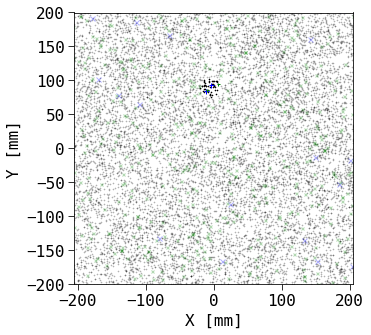

In [8]:
# Plot targets
from numpy import array
from matplotlib import pyplot as plt
% matplotlib inline
f = plt.figure(figsize=[5,5])

RMAX = 15.
CENTER = [-5.,90.]

sci = filter(lambda t : class_dict[t].startswith("sci"), targets )
cal = filter(lambda t : class_dict[t].startswith("cal"), targets )
sky = filter(lambda t : class_dict[t].startswith("sky"), targets )

x = array( [targets[t][0] for t in sci])
y = array( [targets[t][1] for t in sci])
ii = ( (x-CENTER[0])**2 + (y-CENTER[1])**2 ) <= RMAX**2
    
plt.plot(x[ii],y[ii],'x', ms=1, color='k')
plt.plot(x[~ii],y[~ii],'x', ms=1, alpha=0.3, color='k')

x = array( [targets[t][0] for t in cal])
y = array( [targets[t][1] for t in cal])
ii = ( (x-CENTER[0])**2 + (y-CENTER[1])**2 ) <= RMAX**2
plt.plot(x[ii],y[ii],'+', ms=5, color='b')
plt.plot(x[~ii],y[~ii],'x', ms=5, alpha=0.3, color='b')

x = array( [targets[t][0] for t in sky])
y = array( [targets[t][1] for t in sky])
ii = ( (x-CENTER[0])**2 + (y-CENTER[1])**2 ) <= RMAX**2
plt.plot(x[ii],y[ii],'+', ms=3, color='g')
plt.plot(x[~ii],y[~ii],'x', ms=3, alpha=0.3, color='g')


plt.ylabel('Y [mm]')
plt.xlabel('X [mm]')
plt.axis("equal")

plt.xlim([-200.,200.])
plt.ylim([-200.,200.])

In [38]:
def buildSurveyPlan(cobras, targets, nreqvisits, visibilities, tclasses, cost_dict, supply_dict, NVISITS, RMAX, CENTER, COBRAS = []):
    print("buildSurveyPlan " )
    
    TARGETS = []

    # generate a directed graph 
    g = SurveyPlan()

    g.visits = range(NVISITS)

    # Add global sink node
    T = Sink("SINK")
    g.add_node(T)

    # Add nodes for the cobras and the cobra visists
    #  and arcs between them
    for cid in cobras:  
        x,y = cobras[cid] 
        if (x-CENTER[0])**2 + (y-CENTER[1])**2 > RMAX**2:
            continue
        if COBRAS != [] and not cid in COBRAS:
            continue
        c = Cobra(id="C_{}".format(cid),x=x,y=y)
        g.add_node(c)
        # replicate node as many times as there are visits
        for visit in range(NVISITS):
            cvid = "C_{}_v{}".format(cid,visit)
            cv = CobraVisit(id=cvid,cobra=c,visit=visit)
            g.add_node(cv)
            g.add_arc(CobraVisitToCobraArc(cv, c))
    
    # Add nodes for target classes
    for tc in unique(tclasses):
        # add target-class super node
        if tc.startswith("sci_"):
            targetClass = SciTargetClass("TClass_{}".format(tc))
            # give target classes all the same cost fro now.
            # we will introduce a machanism to assign a
            # class specific cost later.
            targetClass.cost = cost_dict[tc][0] 
            targetClass.cost_partial_compl = cost_dict[tc][1]
            targetClass.supply = supply_dict[tc]
            g.add_node(targetClass)
        elif tc.startswith("cal_") or tc.startswith("sky_"):
            for visit in g.visits:
                targetClass = CalTargetClass("TClass_{}_v{}".format(tc,visit))
                # give calibration targets a larger cost. 
                # Again, we will introduce a machanism to assign a
                # class specific cost later.
                targetClass.cost = cost_dict[tc]
                targetClass.supply = supply_dict[tc]
                g.add_node(targetClass)
                
        
        # Add costly overflow arc to the target class
        targetClassOverFlowArc = OverflowArc(targetClass.cost, targetClass, T)
        g.add_arc( targetClassOverFlowArc )
    
    # Add nodes for the targets and the target visists
    #  and arcs between them
    for tid,tc,nrv in zip(targets, tclasses, nreqvisits):
        x,y = targets[tid]
        if (x-CENTER[0])**2 + (y-CENTER[1])**2 > RMAX**2:
            continue
        if TARGETS != [] and not tid in TARGETS:
            continue
        if tc.startswith("sci_"):
            t = SciTarget(id="T_{}".format(tid),x=x,y=y)
            t.gain = nrv
            g.add_node( t )
            
            # Add as many TargetVisit nodes for this target as there are visits
            for visit in g.visits:
                tvid = "T_{}_v{}".format(tid,visit)
                tv = TargetVisit(id=tvid,target=t,visit=visit)
                g.add_node( tv )
                e = g.add_arc(TargetToTargetVisitArc(t, tv))

            # Add arc from target class to target
            targetClass = g.sciTargetClasses["TClass_{}".format(tc)]
            targetClass.add_target(t)
            g.add_arc( TargetClassToTargetArc(targetClass, t) )
            
            # Add VERY costly overflow arc from targets to sind
            g.add_arc( OverflowArc(targetClass.cost_partial_compl, t, T) )

        
        elif tc.startswith("cal_") or tc.startswith("sky_"):
            for visit in g.visits:
                # Add as many nodes for each calibration target as there are visits
                t = CalTarget(id="T_{}_v{}".format(tid,visit),x=x,y=y,visit=visit)
                t.gain = 1
                g.add_node( t )
                
                # Add arc from target class to target
                targetClass = g.calTargetClasses["TClass_{}_v{}".format(tc,visit)]
                targetClass.add_target(t)
                g.add_arc( TargetClassToTargetArc(targetClass, t) )  

            
    # Calibration targets only need to be observed once.
    # Remember we replicate calibration targets such that there is one per 
    # observation.
    for tid,t in g.calTargets.iteritems():
         t.gain = 1.

    # Set supply for each science target class. 
    for tcid,targetClass in g.sciTargetClasses.iteritems():
        if targetClass.supply == inf:
            # Rather than using infinite supply (which woudl result in infinite cost)
            # set supply for the targetClasses to number of targets. 
            # I.e. we want to get them all observed (if possible).
            targetClass.supply = len(targetClass.targets)
        
    # Set supply for each calibration target class. 
    for tcid,targetClass in g.calTargetClasses.iteritems():
        if targetClass.supply == inf:
            targetClass.supply = len(targetClass.targets)
        
        
    # Add arcs corresponding to the visibilies, i.e. 
    # to which cobra can observe which target in which exposure
    for id,tc in zip(visibilities, tclasses):
        # these are all the cobras that can reach the target 
        cobra_ids = ["C_{}".format(c) for c in visibilities[id]]
        
        # bail out if its none
        if cobra_ids == []:
            continue
        
        if tc.startswith("sci_"):
            tid="T_{}".format(id)
            # bail out if we didn't include use this target
            if not g.sciTargets.has_key(tid):
                continue
            # For science targets we need to add edges between cobra visits and target visits.
            # So for each visit, link all cobras that can reach
            # a specific target to that target.
            for visit in g.visits:
                
                tvid = "{}_v{}".format(tid,visit)
                tv = g.targetVisits[tvid]
                for cid in cobra_ids:

                    # bail out if we didn't include use this cobra
                    if not g.cobras.has_key(cid):
                        continue
                    cvid = "{}_v{}".format(cid,visit)
                    cv = g.cobraVisits[cvid]
                    a = TargetVisitToCobraVisitArc(tv,cv)
                    e = g.add_arc(a)

        
        if tc.startswith("cal_") or tc.startswith("sky_"):
            # For calibration targets we need to add edges between cobra visits and target (not visit).
            for visit in g.visits:
                for cid in cobra_ids:
                    tid = "T_{}_v{}".format(id,visit)
                    
                    # bail out if we didn't include use this target
                    if not g.calTargets.has_key(tid):
                        continue
                    
                    t = g.calTargets[tid]
                    
                    
                    # bail out if we didn't include use this cobra
                    if not g.cobras.has_key(cid):
                        continue
                    cvid = "{}_v{}".format(cid,visit)
                    
                    
                    cv = g.cobraVisits[cvid]
                    a = TargetVisitToCobraVisitArc(t,cv)
                    e = g.add_arc(a)
                
    return g



# Graph visualisation functions

In [39]:
import matplotlib.pyplot as plt

import matplotlib.lines as mlines
from matplotlib import patches as mpatches
from matplotlib import collections 
import numpy as np

def plotSurveyPlan(g, name=""):
    
    def nlabel(ax, xy, text):
        y = xy[1] - 0.  # shift y-value for label so that it's below the artist
        x = xy[0] + 0.015  # shift x-value for label so that it's next to the artist
        ax.text(x, y, text, family='sans-serif', ha = 'left', va='center', fontsize=6)

    def plotNodes(ax, nodes, x, color, label, allnodes):
        # targets
        N = len(nodes)
        grid = [[x, 1. - (float(i)+1.)/float(N+1)] for i in range(N)]
        patches = []
        for i,(id,n) in enumerate(nodes.iteritems()):
            n.px,n.py = grid[i]
            circle = mpatches.Circle(grid[i],.01, facecolor=color, edgecolor='grey', lw=1.)
            patches.append(circle)
            nlabel(ax, grid[i], id)
            
        collection = collections.PatchCollection(patches, match_original=True)
        
        ax.add_collection(collection)
        allnodes += nodes.keys()
        plt.text(x,0.,label, ha = 'center', va='top')
     
    def plotArcs(ax, g, allnodes):
        for a in g.arcs.itervalues():
            n1,n2 = a.startnode,a.endnode
            if n1.id in allnodes and n2.id in allnodes:
                # add a line
                x, y = np.array([[n1.px,n2.px], [n1.py,n2.py]])
                lw = a.flow * 2 + 1.
                line = mlines.Line2D(x , y , lw=lw, alpha=.3,zorder=0)
                ax.add_line(line)

    
    cmap=plt.cm.hsv
              
    if True:
        fig = plt.figure(figsize=[15,15])
        # science targets
        ax = plt.subplot(111) # note we must use plt.subplots, not plt.subplot
        allnodes = [] # keep track of nodes actually contained in the plot
        plotNodes(ax, nodes=g.cobras, x=0.9, label="cobras", color="#19967d", allnodes=allnodes)
        plotNodes(ax, nodes=g.cobraVisits, x=0.7, label="cobras\nvisits", color="#99d5ca", allnodes=allnodes)
        plotNodes(ax, nodes=g.targetVisits, x=0.5, label="target\nvisits", color="#ffbbb1", allnodes=allnodes)
        plotNodes(ax, nodes=g.sciTargets, x=0.3, label="science\ntargets", color="#ff8f80", allnodes=allnodes)
        plotNodes(ax, nodes=g.sciTargetClasses, x=0.1, label="science\ntarget\nclasses", color="#c92d39", allnodes=allnodes)
        plotArcs(ax, g, allnodes)
        ax.set_ylim([-.0,1.0])
        ax.set_xlim([-.0,1.0])
        plt.axis('off')
        plt.savefig("{}_sci.pdf".format(name))
            
    if True:
        fig = plt.figure(figsize=[15,15])
        # calibration targets
        ax = plt.subplot(111) # note we must use plt.subplots, not plt.subplot
        allnodes = []
        plotNodes(ax, nodes=g.cobras, x=0.9, label="cobras", color="#19967d", allnodes=allnodes)
        plotNodes(ax, nodes=g.cobraVisits, x=0.7, label="cobras\nvisits",color="#99d5ca", allnodes=allnodes)
        plotNodes(ax, nodes=g.calTargets, x=0.4, label="calib\ntargets",color="#ffeca9", allnodes=allnodes)
        plotNodes(ax, nodes=g.calTargetClasses, x=0.2, label="calib.\ntarget\nclasses",color="#ef8d22", allnodes=allnodes)
        plotArcs(ax, g, allnodes)
        ax.set_ylim([-.0,1.0])
        ax.set_xlim([-.0,1.0])
        plt.axis('off')
        
        plt.savefig("{}_cal.pdf".format(name))

In [40]:
import matplotlib.pyplot as plt

import matplotlib.lines as mlines
from matplotlib import patches as mpatches
from matplotlib import collections 
import numpy as np

def plotFocalPlane(g, visit, summary, XC=0., YC=0., W=400., name=""):
    
    def nlabel(ax, xy, text):
        y = xy[1] - 0.  # shift y-value for label so that it's below the artist
        x = xy[0] + 0.015  # shift x-value for label so that it's next to the artist
        ax.text(x, y, text, family='sans-serif', ha = 'left', va='center', fontsize=6)

    def plotNodes(ax, nodes, color, label, allnodes):
        # targets
        N = len(nodes)
        patches = []
        for i,(id,n) in enumerate(nodes.iteritems()):
            n.px,n.py = n.x,n.y
            circle = mpatches.Circle((n.x,n.y),.75, facecolor=color, edgecolor='grey', lw=1.)
            patches.append(circle)
            
        collection = collections.PatchCollection(patches, match_original=True)
        ax.add_collection(collection)
        allnodes += nodes.keys()
     
    def plotArcs(ax, g, allnodes, visit):
        for a in g.arcs.itervalues():
            n1,n2 = a.startnode,a.endnode
            if a.flow > 0.:
                alpha = 1.
            else:
                alpha = .2
                        
            if type(n2) == CobraVisit and n2.visit == visit and type(n1) == TargetVisit:
                    x, y = np.array([[n1.target.x,n2.cobra.x], [n1.target.y,n2.cobra.y]])

                    line = mlines.Line2D(x , y, lw=1, alpha=alpha, zorder=10)
                    ax.add_line(line)
            if type(n2) == CobraVisit and n2.visit == visit and type(n1) == CalTarget:
                    x, y = np.array([[n1.x,n2.cobra.x], [n1.y,n2.cobra.y]])
                    
                    line = mlines.Line2D(x , y, lw=1, alpha=alpha, zorder=10)
                    ax.add_line(line)                    

    
    cmap=plt.cm.hsv
              

    fig = plt.figure(figsize=[15,15])
    # science targets
    ax = plt.subplot(111) # note we must use plt.subplots, not plt.subplot
    allnodes = [] # keep track of nodes actually contained in the plot
    plotNodes(ax, nodes=g.cobras, label="cobras", color="#19967d", allnodes=allnodes)
    plotNodes(ax, nodes=g.sciTargets, label="science\ntargets", color="#ff8f80", allnodes=allnodes)
    plotNodes(ax, nodes=g.calTargets, label="calib\ntargets",color="#ffeca9", allnodes=allnodes)
    plotArcs(ax, g, allnodes, visit)

    ax.set_ylim([YC-W/2.,YC+W/2.])
    ax.set_xlim([XC-W/2.,XC+W/2.])
    plt.axis('off')
    plt.text(-0.1,-0.1, summary, ha='left', va='bottom', transform=ax.transAxes, fontsize=8)
    plt.text(0.5,1.0, "visit {}/{}".format(visit+1,len(g.visits)), ha='center', va='top', transform=ax.transAxes)
    plt.savefig("{}_visit{}_fp.pdf".format(name,visit))


#for a in g.arcs.itervalues():
#    k = '{}={}'.format(a.startnode.id,a.endnode.id)
#    if flows.has_key(k):
#        a.flow = value(flows[k])

#for v in range(NVISITS):
#    plotFocalPlane(g, v, summary, XC=-5., YC=90, W=110)


In [41]:
def printSurveyPlan(g):
    print("Visits: {}".format(g.visits))
    for cid in g.cobras:
        print("Cobra {}".format(cid))
    for cvid in g.cobraVisits:
        print("CobraVisit {}".format(cvid))
    for tid in g.sciTargetClasses:
        print("SciTargetClass {}".format(tid))
    for tid in g.calTargetClasses:
        print("CalTargetClass {}".format(tid))
    for tid in g.calTargets:
        print("CalTarget {}".format(tid))
    for tid in g.sciTargets:
        print("SciTarget {}".format(tid))
    for tvid in g.targetVisits:
        print("TargetVisit {}".format(tvid))

        
def printCalSurveyPlan(g):
    allnodes = []
    
    print("Visits: {}".format(g.visits))
    for tid in g.calTargetClasses:
        print("CalTargetClass {}".format(tid))
    allnodes += g.calTargetClasses.keys()
    
    for tid in g.calTargets:
        print("CalTarget {}".format(tid))
    allnodes += g.calTargets.keys()
    
    for aid,a in g.arcs.iteritems():
        n1,n2 = a.startnode,a.endnode
        if n1.id in allnodes and n2.id in allnodes:
                
            print("Arc {}".format(aid))

        
def printSciSurveyPlan(g):
    allnodes = []
    
    print("Visits: {}".format(g.visits))
    for tid in g.sciTargetClasses:
        print("SciTargetClass {}".format(tid))
    allnodes += g.sciTargetClasses.keys()
    
    for tid in g.sciTargets:
        print("SciTarget {}".format(tid))
    allnodes += g.sciTargets.keys()
    
    for tvid in g.targetVisits:
        print("TargetVisit {}".format(tvid))
    allnodes += g.targetVisits.keys()
    
    for aid,a in g.arcs.iteritems():
        n1,n2 = a.startnode,a.endnode
        if n1.id in allnodes and n2.id in allnodes:
                
            print("Arc {}".format(aid))

    
#printSciSurveyPlan(g)

# Building the LP problem, sloving it and computing statistics

In [42]:
# Build LP problem
import pulp
from pulp import LpVariable, LpProblem, LpMinimize, GLPK, LpStatus, value, CPLEX, COIN, COIN_CMD
import time
from numpy import random

def buildLPProblem(g, name="MinCostFlowTest", RSEP=5.):
    start_time = time.time()

    prob = LpProblem(name, LpMinimize)
    flows = {}
    
    def addFlow(flows, n, l, u=None):
        f = LpVariable(n, l, u, cat='Integer')
        #f = LpVariable(n, l, u, cat='continuous')
        flows[f.name] = f

    # add flow variables for target class to target arcs
    for tcid,tc in g.sciTargetClasses.iteritems():
        for tid,t in tc.targets.iteritems():
            addFlow(flows, "{}={}".format(tc.id,t.id), 0, 1) # capacity of one
    
    # add flow variables for target to target visits
    for tid,t in g.sciTargets.iteritems():
        for visit in g.visits:
            addFlow(flows, r"{}={}_v{}".format(t.id,t.id,visit), 0, 1) # capacity of one
            #print r"{}={}_v{}".format(t.id,t.id,visit)

    # add flow variables for target visit to cobra visit arcs
    for aid,a in g.arcs.iteritems():
        if type(a) == TargetVisitToCobraVisitArc:
            addFlow(flows, "{}={}".format(a.startnode.id,a.endnode.id), 0,1)

    # add flow variables for cobra visit to cobra arcs
    for cid,c in g.cobras.iteritems():
        for visit in g.visits:
            addFlow(flows, "{}_v{}={}".format(c.id,visit,c.id), 0, 1) 

    # add flow for overflow arc from targetClass node
    # mF: evetually marry with loop above, keep separate for readibility now.
    for tcid,tc in g.sciTargetClasses.iteritems():
        addFlow(flows, "{}=SINK".format(tcid),0,1e6) 

    # add flow for overflow arcs from science target nodes
     # mF: evetually marry with loop above, keep separate for readibility now.
    for tid,t in g.sciTargets.iteritems():
        addFlow(flows, "{}=SINK".format(tid),0,1e6) 
          
    # Now add constraints: At every intermediate node, inflow (* gain) = outflow
    for tcid,tc in g.sciTargetClasses.iteritems():
        # for now set supply equal to number of targets in that target
        # class, i.e. Ideally we get them all observed.
        # If it is sufficient to observe a subset (i.e. N out of M) then this needs to be modified.
        S = tc.supply
        prob += pulp.lpSum([ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in tc.outarcs]) == S
    
    # target nodes
    for tid,t in g.sciTargets.iteritems():
        prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.inarcs]) * t.gain == \
            pulp.lpSum([ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs])
    
    # target visit nodes
    for tv in g.targetVisits.itervalues():
            prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in tv.inarcs]) == \
                sum([ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in tv.outarcs])

    # cobra visit nodes
    for cvid,cv in g.cobraVisits.iteritems():
        prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in cv.inarcs]) == \
            pulp.lpSum([ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in cv.outarcs])
    
    ### for calibration targets
    INCLUDE_CALIB = True
    if INCLUDE_CALIB:
        # add flow variables for calib. target class to target arcs
        for tcid,tc in g.calTargetClasses.iteritems():
            for tid,t in tc.targets.iteritems():
                addFlow(flows, "{}={}".format(tc.id,t.id), 0, 1) # capacity of one
        
        # add flow for overflow arc from calib. targetClass node
        for tcid,tc in g.calTargetClasses.iteritems():
            addFlow(flows, "{}=SINK".format(tcid),0,1e6) 
        
        # add flow for overflow arcs from calibb. target nodes
         # mF: eventually marry with loop above, keep separate for readibility now.
        #for tid,t in g.calTargets.iteritems():
        #    addFlow(flows, "{}=SINK".format(tid),0,1e6) 

        # Now add constraints: At every intermediate node, inflow (* gain) = outflow
        for tcid,tc in g.calTargetClasses.iteritems():
            # for now set supply equal to number of targets in that target
            # class, i.e. Ideally we get them all observed.
            # If it is sufficient to observe a subset (i.e. N out of M) then this needs to be modified.
            S = tc.supply
            prob += pulp.lpSum([ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in tc.outarcs]) == S
        
        # target nodes
        for tid,t in g.calTargets.iteritems():
            prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.inarcs]) * t.gain == \
                pulp.lpSum([ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs])
    ###
    
    


    print("Building cost equation ...")
    # attribute cost to the flows along the overflow arcs
    # Cost occures in two ways for now, either by 
    # flow occuring from a targetClass to the sink node (targets do not get observed at all)
    # or flow from a trget node to the sink node (target was only partially observed)
   
    cost = LpVariable("cost", 0) 
        
    if INCLUDE_CALIB:
        prob += cost ==  \
            pulp.lpSum([tc.cost * flows['{}=SINK'.format(tcid)] for tcid,tc in g.sciTargetClasses.iteritems() ])\
         +  pulp.lpSum([tc.cost_partial_compl * flows['{}=SINK'.format(tid)] for tid in g.sciTargets ])\
         +  pulp.lpSum([tc.cost               * flows['{}=SINK'.format(tcid)] for tcid,tc in g.calTargetClasses.iteritems() ])
    else:
        prob += cost ==  \
            sum([tc.cost *               flows['{}=SINK'.format(tcid)] for tcid,tc in g.sciTargetClasses.iteritems() ])\
         +  sum([tc.cost_partial_compl * flows['{}=SINK'.format(tid)] for tid in g.sciTargets ])

    prob += cost
    time_to_finish = time.time() - start_time
    print(" Time to completion: {:.2f} s".format(time_to_finish))
        
    return prob, flows, cost


#prob, flows, cost = buildLPProblem(g)

In [43]:
def solve(prob, maxSeconds=5):
    #status = prob.solve()
    #status = prob.solve(GLPK(msg = 1, keepFiles=1))
    #status = prob.solve(COIN(msg = 1, keepFiles=1, maxSeconds=maxSeconds))
    status = prob.solve(COIN_CMD(msg = 1, keepFiles=1, maxSeconds=maxSeconds, threads=6, dual=10.))
    #status = prob.solve(CPLEX(msg = 1, keepFiles=1))
    return status

#solve(prob, maxSeconds=5)

In [44]:
from collections import namedtuple
from numpy import nan

def computeStats(g, flows, cost):
    Stats = namedtuple('Stats', \
        ['cost', 'NSciObs', 'NCalObs', 'NSciComplete', 'NCalComplete', 'Noverflow', 'Ncobras_used', 'Ncobras_fully_used'])

    NSciObs = 0
    NSciComplete = 0
    NCalObs = nan
    NCalComplete = nan
    for t in g.sciTargets.itervalues():
        NSciObs += value(sum([flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.inarcs]))
        NSciComplete += int(sum([ value(flows['{}={}'.format(a.startnode.id,a.endnode.id)]) for a in t.outarcs]) == t.gain) 

    #for t in g.sciTargets.itervalues():
    #    print t.id
    #    for a in t.outarcs:
    #        f = value(flows['{}={}'.format(a.startnode.id,a.endnode.id)])
    #        print " flow {}".format(f)
        
    Noverflow = 0
    for tcid,tc in g.sciTargetClasses.iteritems():
        Noverflow += value(flows['{}={}'.format(g.arcs["{}->SINK".format(tcid)].startnode.id,g.arcs["{}->SINK".format(tcid)].endnode.id)])

    Ncobras_used = 0
    Ncobras_fully_used = 0
    for c in g.cobras.itervalues():
        v = value(sum([flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in c.inarcs]))
        Ncobras_used += int(v>0)
        Ncobras_fully_used += int(v == NVISITS)
        
    return Stats(value(cost), NSciObs, NCalObs, NSciComplete, NCalComplete, Noverflow, Ncobras_used, Ncobras_fully_used)

#stats = computeStats(g, flows, cost)
#print stats.NSciObs
#print stats.NSciComplete

# Execute it

In [45]:
# Here we define the costs

cost_dict = {}
# For each target class we define the cost of non-observation
# and non-completion as a two-tuple. The cost of non-completion 
# is typically larger as partial completion of objects shoudl be avoided.
cost_dict['sci_P1'] = (1000.,1e9)
cost_dict['sci_P2'] = (100.,1e9)
cost_dict['sci_P3'] = (10.,1e9)

# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P1'] = 10000.
cost_dict['sky_P1'] = 10000.

# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P1'] = inf
supply_dict['sci_P2'] = inf
supply_dict['sci_P3'] = inf

# need one calibration star per exposure
supply_dict['cal_P1'] = 1 # inf = try to get as amny as  possible
# need one sky positions per exposure
supply_dict['sky_P1'] = 1 # inf = try to get as amny as  possible



Creating graph ...
buildSurveyPlan 
Done.
Number of observable calibration stars: 2
Number of observable sky positions: 2


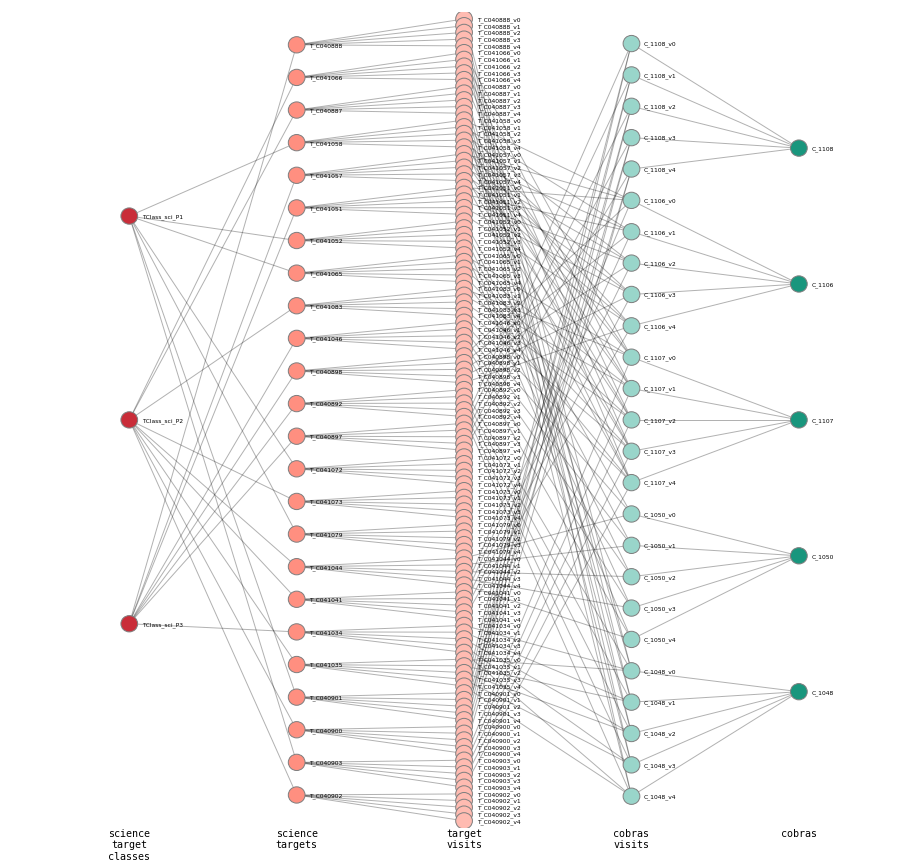

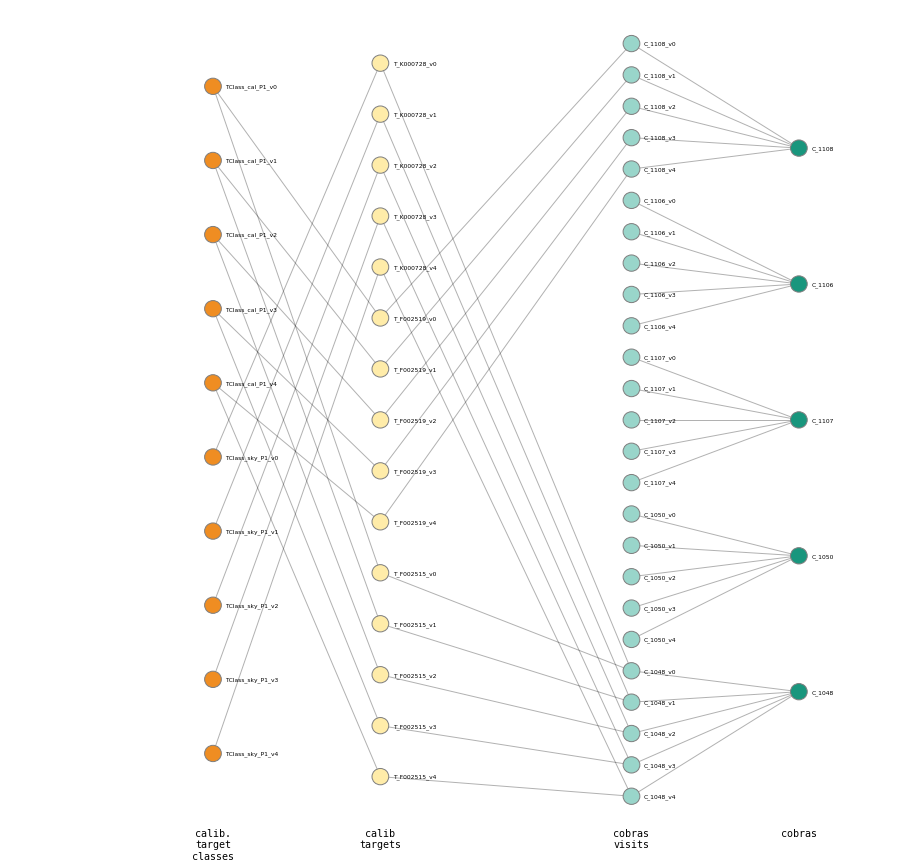

In [46]:
def pp(s):
    print(s)
    return s + "\n"

NVISITS = 5
COBRAS = []



# intermediate examples
RMAX = 50.
CENTER = [-5.,90.]
name="intermediate"

# do them all!
RMAX = 300.
CENTER = [-0.,0.]
name="all"

# good minimal example
RMAX = 10.
CENTER = [-5.,90.]
name="minimal"


print("Creating graph ...")
g = buildSurveyPlan(cobras, targets, nreqvisits, visibilities, tclasses, cost_dict, supply_dict, NVISITS, \
                    RMAX, CENTER, COBRAS = COBRAS)
print("Done.")

print("Number of observable calibration stars: {}".format(len(g.calTargetClasses['TClass_cal_P1_v0'].targets)) )
print("Number of observable sky positions: {}".format(len(g.calTargetClasses['TClass_cal_P1_v0'].targets)) )

if True:
    plotSurveyPlan(g)

In [51]:
RSEP = 5.

if RSEP > 0.:
    print("Finding collision pairs ...")
    tt = np.array( [t for t in g.targets.itervalues()] )
    tt_xy = [ (g.targets[t].x,g.targets[t].y) for t in g.targets]

    N = len(tt)

    from scipy.spatial import distance
    # calculat collisions from all pairwise separations
    colls = distance.cdist(tt_xy, tt_xy, 'euclidean') < RSEP
    # set lower diagonal to False, if we know that A collides with B already
    # then we don't need to take into account that B collides with A
    colls[ np.tril_indices(N) ] = False 

    coll_pairs = []
    for i,t1 in enumerate(tt):
        for t2 in tt[ colls[i] ].tolist():
            coll_pairs.append([t1,t2])
            #print t1.id,t2.id

    print( "Found {} collision pairs.".format(len( coll_pairs )) )

    #for tid,t in tt:
    #    prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs]) <= 1
    
    

Finding collision pairs ...
Found 195 collision pairs.


In [56]:
i = 0

t1,t2 = coll_pairs[i]

print type(t1) == SciTarget
print type(t1) == CalTarget

t2.outarcs

False
True


In [ ]:
maxSeconds=600.

    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(NCalTargets/NVISITS))
summary += pp(" {} cobras".format(NCobras))
summary += pp("Will stop in any case after {} s.".format(maxSeconds))


summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

#visualizeSurveyPlan(g)

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g)
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()
status = solve(prob, maxSeconds=maxSeconds)
time_to_solve = time.time() - start_time
summary += pp("Solve status is {}.".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))

stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats.cost) ) )
summary += pp("{} out of {} science targets get observed.".format(int(stats.NSciObs),NSciTargets))
summary += pp("For {} out of these all required exposures got allocated.".format(stats.NSciComplete))
summary += pp("{} targets get sent down the overflow arc.".format(stats.Noverflow))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats.Ncobras_used, NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats.Ncobras_fully_used))

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.itervalues():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if flows.has_key(k):
        allflows.append(value(flows[k]))

print("All flows are: integer {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
if True:
    # plot solution
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
    plotSurveyPlan(g)
    #return g, stats, time_to_build, time_to_solve, status, prob, flows, cost, summary

In [ ]:
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

In [57]:
!open .